# Deep Face Detection Model

In [36]:
# !pip install labelme tensorflow opencv-python matplotlib albumentations
# !pip install opencv-contrib-python

### 1.2 Collect  Images Using OpenCV

In [37]:
import os
import time
import uuid
import cv2

In [38]:
IMAGES_PATH = os.path.join('practices/Deep-Learning/model/data')
number_images = 30

In [39]:
# cap = cv2.VideoCapture(0)  # Ensure 0 is the correct device index
# if not cap.isOpened():
#     print("Cannot access the camera")
# else:
#     print("Camera accessed successfully")

In [40]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting Image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(1)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

## !Annotate Images with LabelMe

In [41]:
# !labelme

# Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [42]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [43]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## 2.3 Load Image into TF Data Pipeline

In [44]:
images = tf.data.Dataset.list_files('./model/data/test/images/*.jpg', shuffle=False)

In [45]:
images.as_numpy_iterator().next()

b'.\\model\\data\\test\\images\\5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'

In [46]:
def load_image(X):
    byte_img = tf.io.read_file(X)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [47]:
images = images.map(load_image)

In [48]:
images.as_numpy_iterator().next()

array([[[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [49]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## 2.4 View Raw Images With Matplotlib

In [50]:
image_generator = images.batch(4).as_numpy_iterator()

In [51]:
plot_images = image_generator.next()

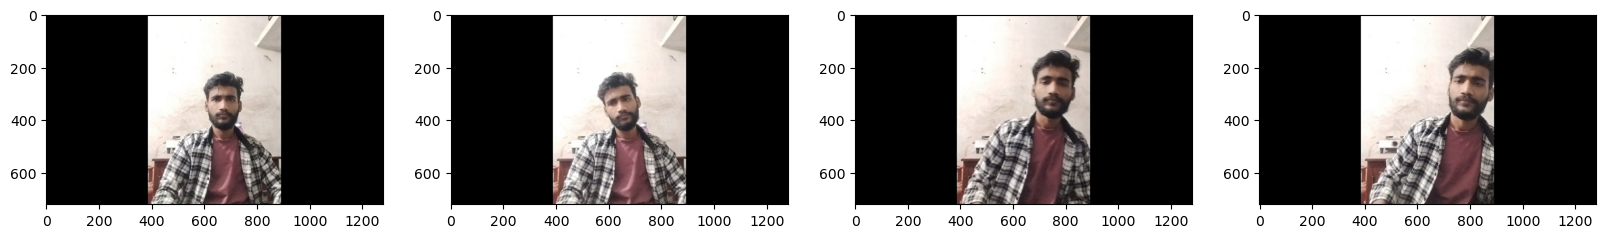

In [52]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 Manually Split Data into train test and val

In [53]:
113 * .7 #79 to train

79.1

In [54]:
113 * .15 # 17 and 17 to test and val

16.95

## 3.2 Move the Matching Labels

In [55]:
# for folder in ['train', 'test', 'val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('data', 'labels', filename)
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join('data', folder, 'labels', filename)
#             os.replace(existing_filepath, new_filepath)

# Albumentations

In [56]:
import albumentations as alb

In [57]:
img = cv2.imread(os.path.join('./model/data/test/images/5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'))

In [58]:
img.shape

(720, 1280, 3)

In [59]:
augmentor = alb.Compose([
    alb.RandomCrop(width=1280, height=720),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
],bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotaition with OpenCv and JSON

In [60]:
img = cv2.imread(os.path.join('./model/data/train/images/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.jpg'))

In [61]:
with open(os.path.join('./model/data/train/labels/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.json'), 'r') as f:label = json.load(f)

In [62]:
label['shapes'][0]['points']

[[550.9756097560976, 206.3414634146342],
 [749.7560975609756, 446.5853658536586]]

### 4.3 Extract Cordintaes and Rescale to Match image Resolution

In [63]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [64]:
coords

[550.9756097560976, 206.3414634146342, 749.7560975609756, 446.5853658536586]

In [65]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [66]:
coords

[0.43044969512195125,
 0.2865853658536586,
 0.5857469512195121,
 0.6202574525745258]

### 4.4 Apply Augmentations and View Results

In [67]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

In [68]:
augmented['image'].shape

(720, 1280, 3)

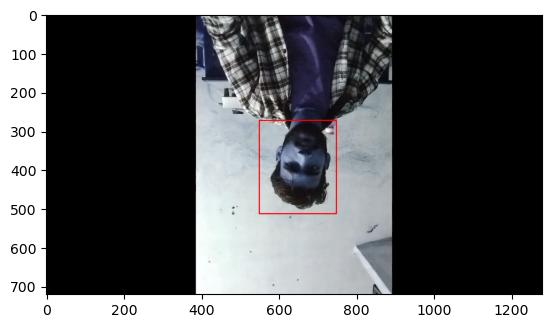

In [69]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [1280,720]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [1280, 720]).astype(int)),
              (255, 0, 0), 2)
plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [70]:
# base_path = './model/data'
# output_path = './model/aug_data'

# for partition in ['train', 'test', 'val']:
#     partition_path = os.path.join(base_path, partition)
#     images_path = os.path.join(partition_path, 'images')
#     labels_path = os.path.join(partition_path, 'labels')

#     aug_images_path = os.path.join(output_path, partition, 'images')
#     aug_labels_path = os.path.join(output_path, partition, 'labels')

#     # Create required directories if they don't exist
#     os.makedirs(aug_images_path, exist_ok=True)
#     os.makedirs(aug_labels_path, exist_ok=True)

#     for image_file in os.listdir(images_path):
#         image_path = os.path.join(images_path, image_file)
#         img = cv2.imread(image_path)

#         if img is None:
#             print(f"Could not read image: {image_file}")
#             continue

#         # Default bounding box coordinates
#         coords = [0, 0, 0.0001, 0.00001]
#         label_file = f'{os.path.splitext(image_file)[0]}.json'
#         label_path = os.path.join(labels_path, label_file)

#         # Load label if it exists
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#             if 'shapes' in label and len(label['shapes']) > 0:
#                 coords[0] = label['shapes'][0]['points'][0][0]
#                 coords[1] = label['shapes'][0]['points'][0][1]
#                 coords[2] = label['shapes'][0]['points'][1][0]
#                 coords[3] = label['shapes'][0]['points'][1][1]
#                 coords = list(np.divide(coords, [1280, 720, 1280, 720]))

#         try:
#             # Generate augmentations
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

#                 # Save augmented image
#                 aug_image_file = f"{os.path.splitext(image_file)[0]}.{x}.jpg"
#                 cv2.imwrite(os.path.join(aug_images_path, aug_image_file), augmented['image'])

#                 # Prepare annotation
#                 annotation = {'image': aug_image_file}

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0:
#                         annotation['bbox'] = [0, 0, 0, 0]
#                         annotation['class'] = 0
#                     else:
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1

#                 # Save annotation
#                 aug_label_file = f"{os.path.splitext(image_file)[0]}.{x}.json"
#                 with open(os.path.join(aug_labels_path, aug_label_file), 'w') as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print(f"Error processing {image_file}: {e}")


### 5.2 Load Augmented Images to Tensorflow Dataset

In [71]:
train_images = tf.data.Dataset.list_files('./model/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [72]:
test_images = tf.data.Dataset.list_files('./model/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [73]:
val_images = tf.data.Dataset.list_files('./model/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

# 6. Prepare Labels

### 6.1 Build Label Loading Function